# Inhalt

    Analyse der Sensordaten
    Analyse der Performance des Förderbandes
    Leistungsverbrauch / Leistungsersparnis
    Diverse Kennzahlen

### Geprüft wird das Förderband zwischen den beiden Sensoren
![title](generated-static-images/b06_and_b09.png)

### Initialisierung

In [1]:
%run ../Setup.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime  
from matplotlib import dates
from datetime import timedelta
from sklearn import preprocessing

from isac.plotting import plot_helper as isac_plotter
from isac.database.connection import database_connector as connector
from isac import configuration
from data_compare import sensor_data_provider as sdp          

In [2]:
dataProvider = sdp.SensorDataProvider()

sensor_in_name = "Bandbero_99_B06_Meldungen"
sensor_out_name = "Bandbero_99_B09_Meldungen"
powermeter_name = "PÜberwachung_ZS_B103_Leistungen"

# Sensordaten
b06 = dataProvider.getSensorData(sensor_in_name)
b09 = dataProvider.getSensorData(sensor_out_name)
b06['Zeit'] = pd.to_datetime(b06['Zeit'], unit='ms')
b09['Zeit'] = pd.to_datetime(b09['Zeit'], unit='ms')

# Leistungsdaten
powermeter = dataProvider.getSensorData(powermeter_name)
powermeter['Zeit'] = pd.to_datetime(powermeter['Zeit'], unit='ms')

### Analyse der in der Datenbank gespeicherten Sensordaten
Immer, wenn ein Sensor ein Signal geliefert hat, bedeutet das, dass ein Werkstückträger von einem der Sensoren erfasst wurde.
Stellt man die beiden Sensoren vor und nach dem Förderband gegenüber, kann man berechnen, wieviele Werkstückträger sich zu jeder Zeit auf dem Förderband befinden.

#### Interpretation der Signale:
    Liefert der Sensor am Förderbandbeginn ein Signal, hat ein Werkstückträger das Förderband erreicht.
    Liefert der Sensor am Förderbandende ein Signal hat ein Werkstückträger das Förderband verlassen.


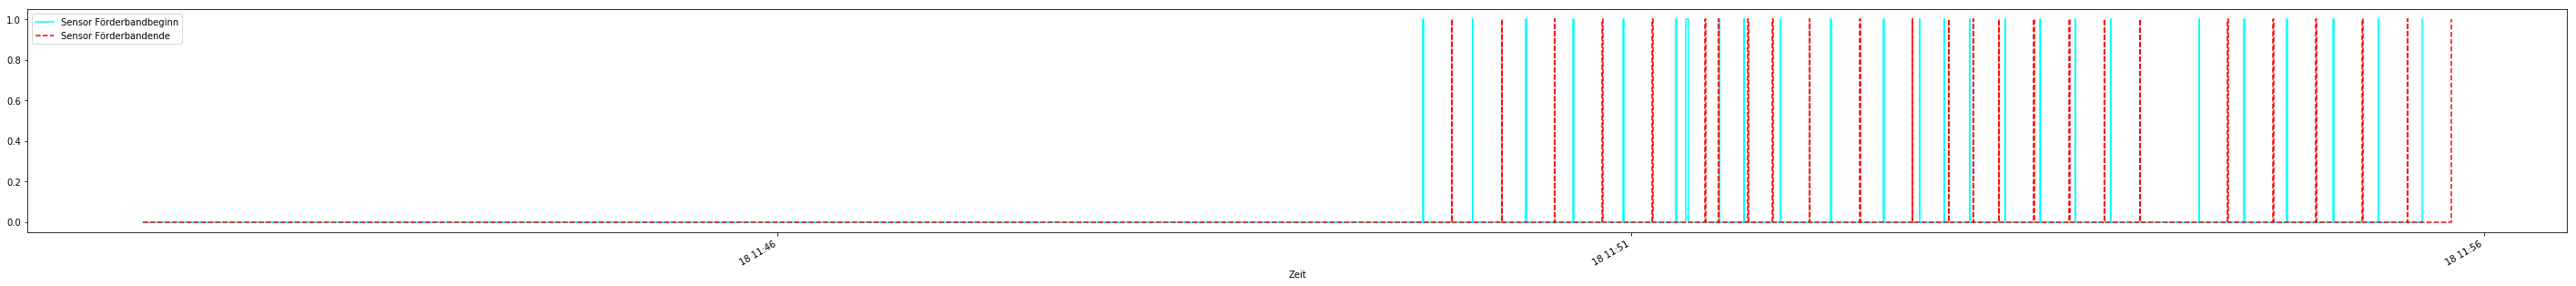

<Figure size 11784x1297 with 0 Axes>

In [3]:
anzahl=50
fig, axes = plt.subplots(figsize=(50,5))
b06.head(anzahl).plot(drawstyle="steps-post", ls="-", label="Sensor Förderbandbeginn", color='cyan', ax=axes, x='Zeit',  y='Wert', linewidth=1.5);
b09.head(anzahl).plot(drawstyle="steps-post", ls="--", label="Sensor Förderbandende", color='red', ax=axes, x='Zeit',  y='Wert', linewidth=1.5);

axes.legend(loc='upper left')

isac_plotter.savePlotLocal("temporary-generated-files/plot-1.png")

#### Remodellierung der Signale am Förderbandende
Wenn der Sensor am Förderbandende ein Signal liefert, hat ein Werkstückträger das Förderband verlassen.
Jeder Spike des sich am Förderbandende befindenden Sensors wird deshalb als Verlassen eines Werkstückträgers vom Förderband interpretiert.

    Der Sensor am Förderbandende liefert negative Werte bei einem erkannten Werkstückträger zurück, um die Anzahl der sich auf dem Förderband befindenden Werkstückträger berechnen zu können.

In [4]:
b09["Wert"] = -b09["Wert"]
b09.head()

,Wert,Zeit,_id
0,0,2018-12-18 11:42:16.890,5c7d26f4d7faa2872626ccdd
1,-1,2018-12-18 11:49:57.093,5c7d26f4d7faa2872626ccd8
2,0,2018-12-18 11:49:57.219,5c7d26f4d7faa2872626ccd6
3,-1,2018-12-18 11:50:14.715,5c7d26f4d7faa2872626ccd9
4,0,2018-12-18 11:50:14.841,5c7d26f4d7faa2872626ccd7


#### Standardfall Sensorsignale
Im Normalfall sollte jeder Sensor beim Durchgang eines Werkstückträgers zwei Signale liefern:

    Erkennen eines neuen Werkstückträgers (Wert: 1)
    Verlassen dieses Werkstückträgers (Wert: 0)
    
Zusätzlich liefert ein Sensor bei Aktivierung des Gesamtsystems ein "Initialisierungs-Signal" (Wert: 0).

#### Erkennung fehlerhafter Sensordaten
Sollten Werkstückträger nicht korrekt erkannt worden sein oder ein technischer Defekt vorliegen, kann es vorkommen, dass Signale nicht oder zu oft getriggert werden.

Um das zu erkennen, werden die vorliegenden Sensordaten auf Gültigkeit überprüft. Nach jedem Eingang eines Werkstückträgers (Spike) muss auch zwingendermaßen wieder ein Verlassen-Signal folgen. Mehrere Signale des gleichen Typs hintereinander sind nicht valide.

Diese False-Positives und False-Negatives können erkannt werden, indem man prüft, ob sich Signale wiederholen. Wiederholen sich Signale eines Sensors, befinden sie sich außerhalb des Gültigkeitsbereiches [0;1] siehe lila-farbene Grafik.

In [5]:
def plotErrors(dataframe):
    for i in range(0, len(dataframe)):
        current_value = abs(dataframe.loc[i, 'Wert'])
        if (current_value == 0):
            current_value = -1

        if (i == 0):
            value_before = 1
            dataframe.loc[i, 'recognize_error'] = value_before + current_value
        else:
            value_before = dataframe.loc[i - 1, 'recognize_error']
            dataframe.loc[i, 'recognize_error'] = value_before + current_value
            
    fig, axes = plt.subplots(figsize=(20,5))
    hfmt = dates.DateFormatter('%H:%M')
    axes.xaxis.set_major_formatter(hfmt)
    dataframe.plot(drawstyle="steps-post", label='Gelieferte Signale des Sensors', color='purple', ax=axes, x='Zeit',  y='recognize_error', linewidth=1.0);
    axes.legend(loc='upper left')

#### Beispiel fehlerhafte Signale Bandbero_99_B06
![title](generated-static-images/ISAC_FOERDERBAND.Bandbero_99_B06_Meldungen.png)

#### Signale am Förderbandbeginn:  Bandbero_99_B06

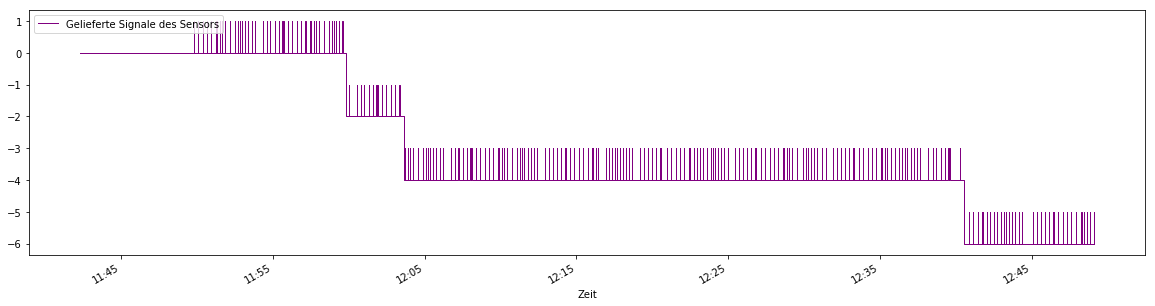

<Figure size 4804x1263 with 0 Axes>

In [6]:
plotErrors(b06)
isac_plotter.savePlotLocal("temporary-generated-files/plot-2.png")

#### Signale am Förderbandende: Bandbero_99_B09

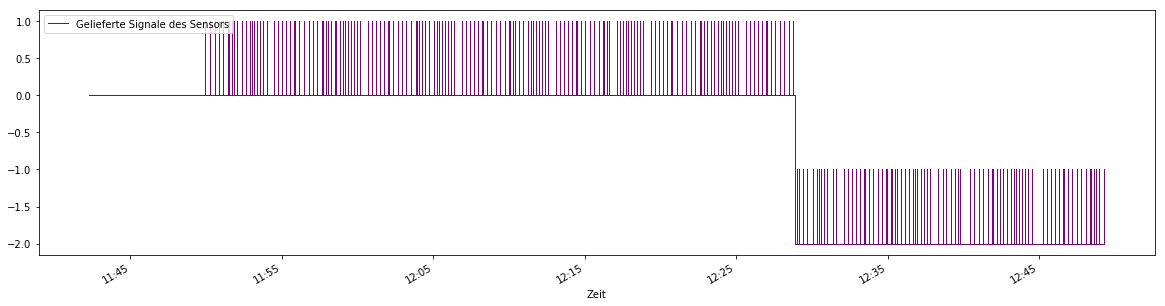

<Figure size 4843x1263 with 0 Axes>

In [7]:
plotErrors(b09)
isac_plotter.savePlotLocal("temporary-generated-files/plot-3.png")

#### Fehlerhafte Sensordaten korrigieren
Nach Sichtung der gelieferten Daten konnten wir feststellen, dass sich immer nur einzelne False-Negatives in den Testdaten befanden. Um diese zu korrigieren, änderten wir die Datensätze der erkannten False-Negatives.

    Ein Datensatz zählt als fehlerhaft, wenn er dem zeitlich vorherigen entspricht.

Hinweis:
In den gelieferten Daten handelte es sich immer nur um einzelne Datensätze, die korrigiert werden mussten (Dementsprechend waren drei Datensätze hintereinander entweder False oder True). Sollten sich andere Fehler eingeschlichen haben, lässt sich dieser nicht mit diesem Ansatz korrigieren.

In [8]:
def fixErrors(dataframe, value_positive):
    for i in range(0, len(dataframe)):
        # Vorheriger Wert
        if (i == 0):
            pass
        else:
            value_before = dataframe.loc[i - 1, 'Wert']
            value_current = dataframe.loc[i, 'Wert']
            
            if (value_before == value_current):
                if (value_current == 0):
                    dataframe.loc[i, 'Wert'] = value_positive
                else:
                    dataframe.loc[i, 'Wert'] = 0
            
    return dataframe

#### Korrigierte Signale am Förderbandende: Bandbero_99_B06

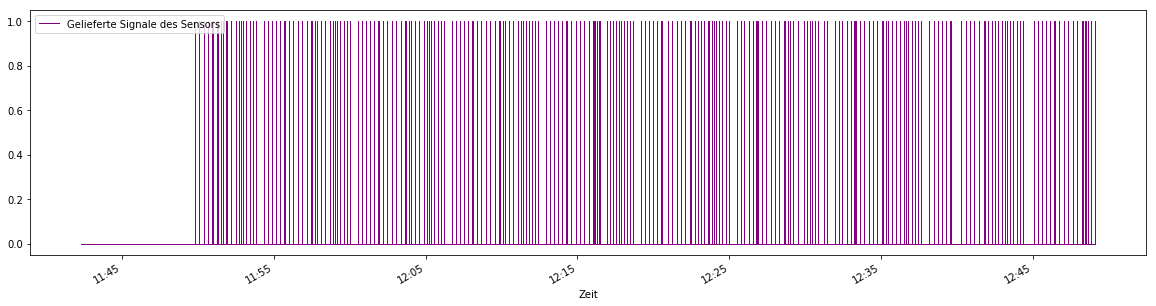

<Figure size 4809x1263 with 0 Axes>

In [9]:
fixedDataframe_1 = fixErrors(b06, 1)
plotErrors(fixedDataframe_1)
isac_plotter.savePlotLocal("temporary-generated-files/plot-4.png")

#### Korrigierte Signale am Förderbandende: Bandbero_99_B09

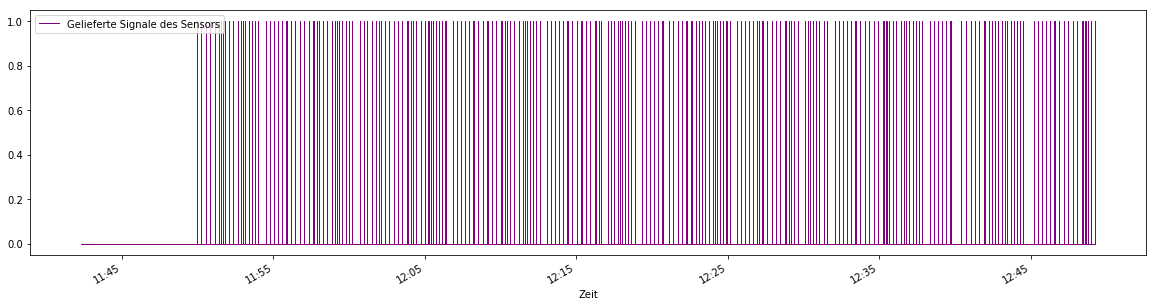

<Figure size 4809x1263 with 0 Axes>

In [10]:
fixedDataframe_2 = fixErrors(b09, -1)
plotErrors(fixedDataframe_2)
isac_plotter.savePlotLocal("temporary-generated-files/plot-5.png")

### Performance des Förderbandes

Zur Berechnung von weiteren Kennzahlen werden die Datensätze der beiden Sensoren zusammengefasst und in einem Datenframe gespeichert. Damit können im Weiteren folgende Aussagen getroffen werden:

    Anzahl Werkstückträger auf dem Förderband
    Aktivität des Förderbandes
    Leistungsersparnis durch Abschaltung bei Inaktivität

In [11]:
# Übernehmen der korrigierten Datensätze
b06 = fixedDataframe_1[["Wert", "Zeit", '_id']]
b09 = fixedDataframe_2[["Wert", "Zeit", '_id']]

# Zusammenfassen der Datensätze aus beiden Sensoren
result = pd.concat([b06, b09])
result = result.sort_values(by=['Zeit'])
result = result.reset_index(drop=True)
result.head()

,Wert,Zeit,_id
0,0,2018-12-18 11:42:16.890,5c7d26e8d7faa28726237a21
1,0,2018-12-18 11:42:16.890,5c7d26f4d7faa2872626ccdd
2,1,2018-12-18 11:49:46.874,5c7d26e8d7faa28726237a22
3,0,2018-12-18 11:49:47.044,5c7d26e8d7faa28726237a27
4,-1,2018-12-18 11:49:57.093,5c7d26f4d7faa2872626ccd8


#### Anzahl der Werkstückträger auf dem Förderband
Die Anzahl der Werkstückträger ergibt sich aus den Signalen der beiden Sensoren am Förderbandbeginn und Förderbandende.
Erkennt der Sensor am Förderbandbeginn einen Werkstückträger, erhöht sich die Anzahl der Werkstückträger auf dem Förderband. Erreicht dieser Werkstückträger den Sensor am Förderbandende, verlässt er das Förderband.

In [12]:
for i in range(0, len(result)):
    # Vorheriger Wert
    if (i == 0):
        blocks_before = 0
        result.loc[i, 'blocksBetween'] = blocks_before + result.loc[i, 'Wert']
    else:
        blocks_before = result.loc[i - 1, 'blocksBetween']
        # Anzahl der Blöcke dazwischen
        result.loc[i, 'blocksBetween'] = blocks_before + result.loc[i - 1, 'Wert']

#### Inaktivität Förderband
Das Förderband wird unnötig angetrieben, wenn sich kein Werkstückträger auf dem Förderband, d.h. zwischen den beiden Sensoren am Anfang und Ende des Förderbandes, befindet.

    Befindet sich kein Werkstückträger auf dem Förderband könnte das Förderband inaktiv geschalten werden.

In [13]:
# Konstante zur Erkennung des IDLE-Status
CONST_IS_IDLE = 0.5

for i in range(0, len(result)):
    if (result.loc[i, 'blocksBetween'] == 0):
        result.loc[i, 'is_idle'] = CONST_IS_IDLE
    else:
        result.loc[i, 'is_idle'] = 0

result.head(8)

,Wert,Zeit,_id,blocksBetween,is_idle
0,0,2018-12-18 11:42:16.890,5c7d26e8d7faa28726237a21,0.0,0.5
1,0,2018-12-18 11:42:16.890,5c7d26f4d7faa2872626ccdd,0.0,0.5
2,1,2018-12-18 11:49:46.874,5c7d26e8d7faa28726237a22,0.0,0.5
3,0,2018-12-18 11:49:47.044,5c7d26e8d7faa28726237a27,1.0,0.0
4,-1,2018-12-18 11:49:57.093,5c7d26f4d7faa2872626ccd8,1.0,0.0
5,0,2018-12-18 11:49:57.219,5c7d26f4d7faa2872626ccd6,0.0,0.5
6,1,2018-12-18 11:50:04.451,5c7d26e8d7faa28726237a1f,0.0,0.5
7,0,2018-12-18 11:50:04.619,5c7d26e8d7faa28726237a20,1.0,0.0


### Visualisierung der Werkstückträger auf dem Förderband

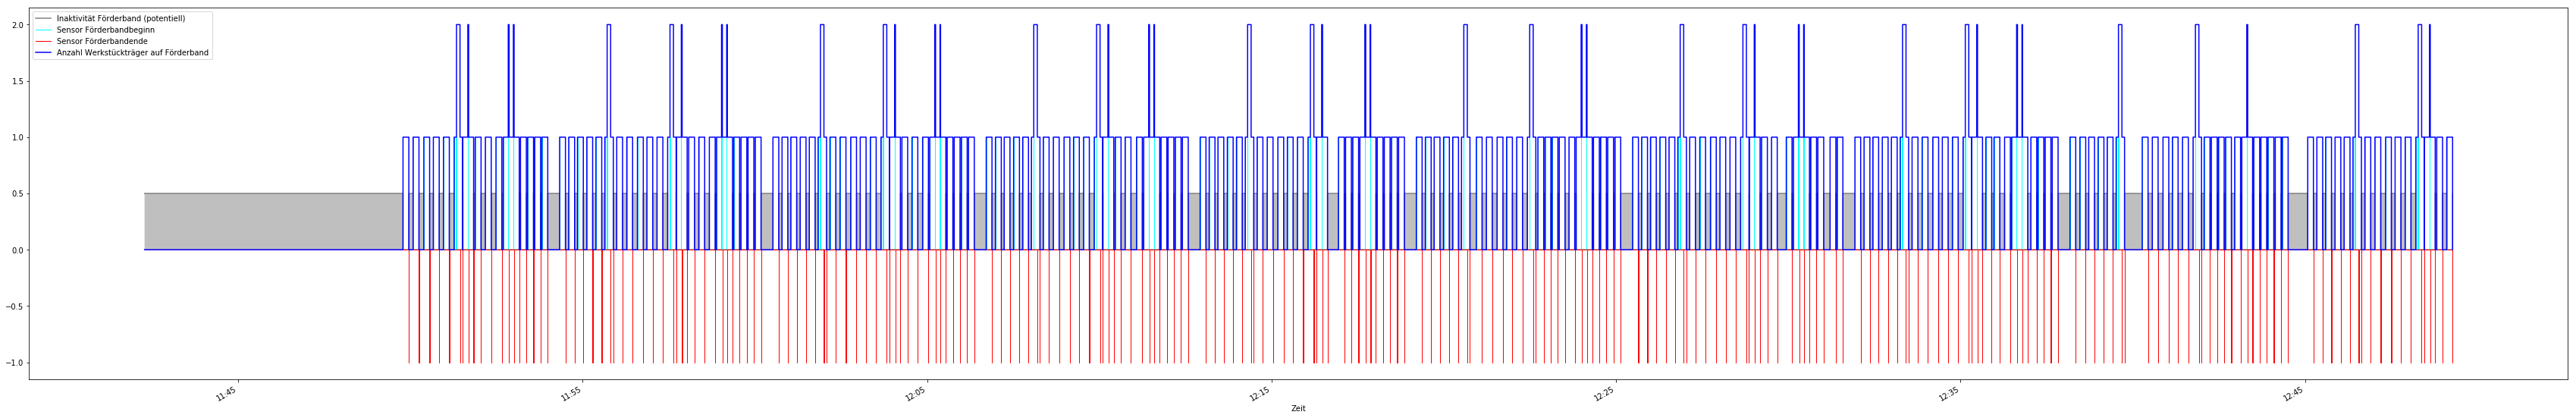

<Figure size 14143x2283 with 0 Axes>

In [14]:
fig, axes = plt.subplots(figsize=(60,10))
result['Zeit'] = pd.to_datetime(result['Zeit'], unit='ms')
hfmt = dates.DateFormatter('%H:%M')
axes.xaxis.set_major_formatter(hfmt)

anzahl = 2000
axes.fill_between(result['Zeit'].values, result['is_idle'], 0, facecolor='grey', alpha=0.5, step="post")

result.head(anzahl * 2).plot(label="Inaktivität Förderband (potentiell)", drawstyle="steps-post", color='grey', ax=axes, x='Zeit',  y='is_idle');
b06.head(anzahl).plot(label="Sensor Förderbandbeginn", drawstyle="steps-post", color='cyan', ax=axes, x='Zeit',  y='Wert', linewidth=1.0);
b09.head(anzahl).plot(label="Sensor Förderbandende", drawstyle="steps-post", color='red', ax=axes, x='Zeit',  y='Wert', linewidth=1.0);
result.head(anzahl * 2).plot(label="Anzahl Werkstückträger auf Förderband", drawstyle="steps-post", color='blue', ax=axes, x='Zeit',  y='blocksBetween');

axes.legend(loc='upper left')

isac_plotter.savePlotLocal("temporary-generated-files/plot-6.png")

### Kumulierte potentielle Aktivität bzw. Inaktivität des Förderbandes
Das Förderband ist aktiv, wenn sich mindestens ein Werkstückträger auf dem Förderband befindet.

In [15]:
for i in range(0, len(result)):
    if (i == 0):
        # Init
        result.loc[i, 'time_idle'] = timedelta()
        result.loc[i, 'time_active'] = timedelta()
        result.loc[i, 'time_sum'] = timedelta()
        continue
        
    if (result.loc[i, 'is_idle'] == 0):
        result.loc[i, 'time_active'] = result.loc[i, 'Zeit'] - result.loc[i - 1, 'Zeit'] + result.loc[i - 1, 'time_active']
        result.loc[i, 'time_idle'] = result.loc[i - 1, 'time_idle']
    else:
        result.loc[i, 'time_idle'] = result.loc[i, 'Zeit'] - result.loc[i - 1, 'Zeit'] + result.loc[i - 1, 'time_idle']
        result.loc[i, 'time_active'] = result.loc[i - 1, 'time_active']
        
    result.loc[i, 'time_sum'] = result.loc[i, 'time_active'] + result.loc[i, 'time_idle']

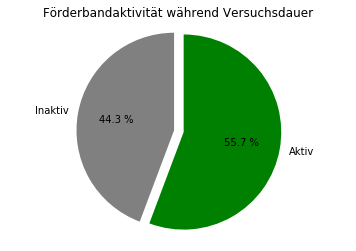

<Figure size 1462x1032 with 0 Axes>

In [16]:
labels = 'Inaktiv', 'Aktiv'
colors = ['grey', 'green']

sizes = [result['time_idle'].max().microseconds,   # Förderband Inaktiv
         result['time_active'].max().microseconds] # Förderband Aktiv
explode = (0, 0.1)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f %%', startangle=90, colors=colors)
ax.axis('equal')

plt.title("Förderbandaktivität während Versuchsdauer")

isac_plotter.savePlotLocal("temporary-generated-files/plot-7.png")

plt.show()

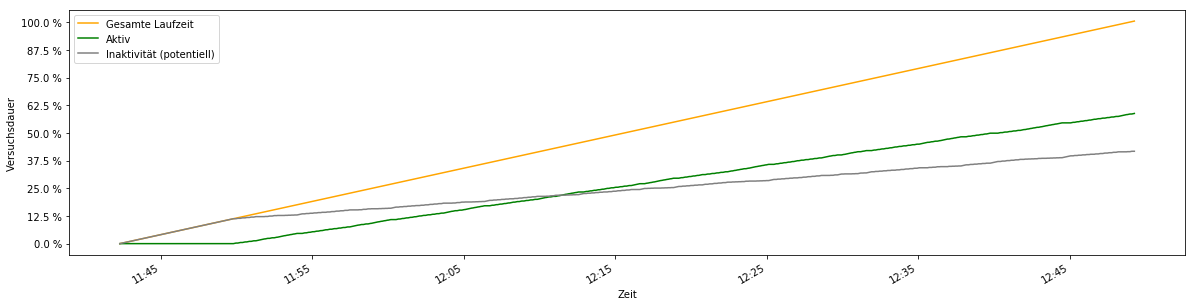

<Figure size 4971x1263 with 0 Axes>

In [17]:
fig, axes = plt.subplots(figsize=(20,5))
hfmt = dates.DateFormatter('%H:%M')
axes.xaxis.set_major_formatter(hfmt)

def versuchsdauer_pct(in_value_in_seconds, pos=None):
    return str((pos - 1) * 12.5) + ' %'

axes.yaxis.set_major_formatter(plt.FuncFormatter(versuchsdauer_pct))
axes.set_ylabel("Versuchsdauer")

result.plot(label="Gesamte Laufzeit", color='orange', ax=axes, x='Zeit', y='time_sum');
result.plot(label="Aktiv", color='green', ax=axes, x='Zeit', y='time_active');
result.plot(label="Inaktivität (potentiell)", color='grey', ax=axes, x='Zeit', y='time_idle');

axes.legend(loc='upper left')

isac_plotter.savePlotLocal("temporary-generated-files/plot-8.png")

### Übersicht Verbrauch

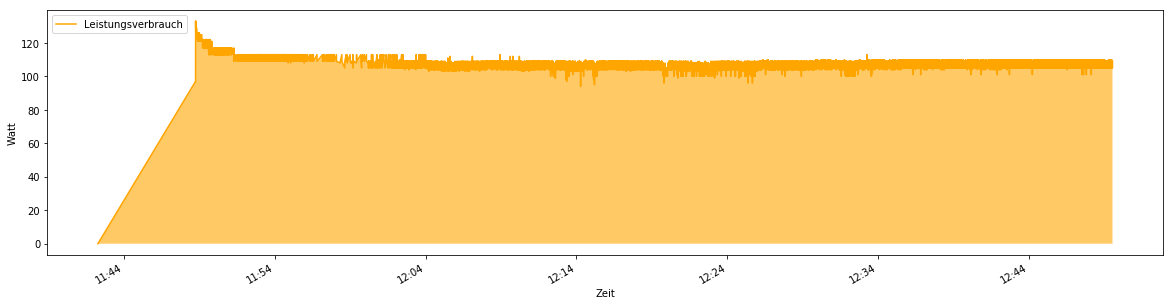

<Figure size 4878x1263 with 0 Axes>

In [18]:
fig, axes = plt.subplots(figsize=(20, 5))
axes.set_ylabel("Watt")
hfmt = dates.DateFormatter('%H:%M')
axes.xaxis.set_major_formatter(hfmt)

powermeter.plot(label="Leistungsverbrauch", color='orange', ax=axes, x='Zeit', y='Wert');
axes.fill_between(powermeter['Zeit'].values, powermeter['Wert'], facecolor='orange', alpha=0.6,)

axes.legend(loc='upper left')

isac_plotter.savePlotLocal("temporary-generated-files/plot-9.png")

### Leistungsverbrauch im Vergleich zu auf dem Förderband befindlichen Werkstückträgern
Frage: Ist die Anzahl der Werkstückträger auf dem Förderband im Leistungsverbrauch erkennbar?

Antwort: Nach Sichtung der Daten sind keine relevanten Spikes im Verbrauch in Abhängigkeit zu den auf dem Förderband befindlichen Werkstückträgern sichtbar.

In [19]:
# Normalisierung des Leistungsverbrauches
powermeter_norm = powermeter[100:].copy()

x = powermeter_norm[["Wert"]].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
powermeter_norm["Wert"] = pd.DataFrame(x_scaled)

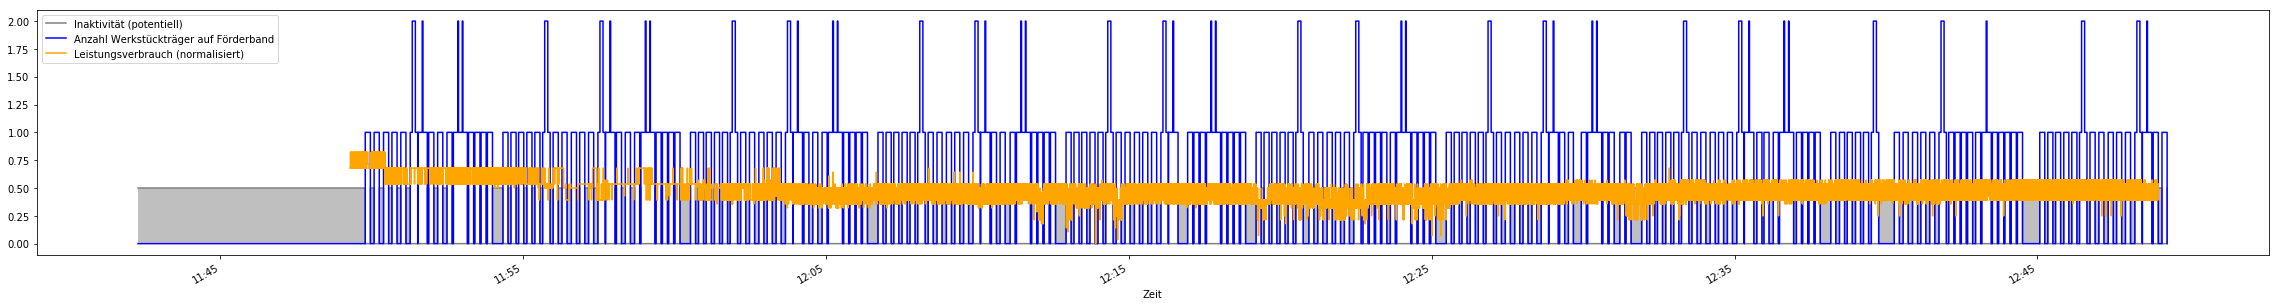

<Figure size 9485x1263 with 0 Axes>

In [20]:
fig, axes = plt.subplots(figsize=(40,5))
hfmt = dates.DateFormatter('%H:%M')
axes.xaxis.set_major_formatter(hfmt)

axes.fill_between(result['Zeit'].values, result['is_idle'], 0, facecolor='grey', alpha=0.5, step="post")
result.plot(label="Inaktivität (potentiell)", drawstyle="steps-post", color='grey', ax=axes, x='Zeit',  y='is_idle');
result.plot(label="Anzahl Werkstückträger auf Förderband", drawstyle="steps-post", color='blue', ax=axes, x='Zeit',  y='blocksBetween');
powermeter_norm.plot(label="Leistungsverbrauch (normalisiert)", drawstyle="steps-post", color='orange', ax=axes, x='Zeit',  y='Wert');

axes.legend(loc='upper left')

isac_plotter.savePlotLocal("temporary-generated-files/plot-10.png")

### Leistungsersparnis durch Abschaltung bei Inaktivität des Förderbands
Um die potentielle Ersparnis bei der Abschaltung des Förderbandes bei Inaktivität zu berechnen, werden die Sensordaten mit den Leistungsverbrauchsdaten miteinander verknüpft.

Anhand der Sensordaten kann gefiltert werden, wann das Förderband abgeschaltet werden könnte und somit in Abhängigkeit der derzeit verbrauchten Leistung die potentielle Leistungsersparnis berechnet werden.

In [21]:
# Zusammenfügen der Daten
powermeter["is_powermeter_sensor"] = 0
merged_frames = pd.concat([result, powermeter], sort=True)
merged_frames = merged_frames.sort_values(by=['Zeit'])
merged_frames = merged_frames.reset_index(drop=True)

#### Berechnung der Zeiten, in denen das Förderband inaktiv sein könnte

In [22]:
def getInactivePowermeterDataframe(dataframe):
    is_idle = True
    for i in range(0, len(dataframe)):
        value_is_powermeter = dataframe.loc[i, 'is_powermeter_sensor']
        if (value_is_powermeter == 0):
            # Powermeter Sensoreintrag
            if is_idle:
                dataframe.loc[i, 'is_idle'] = 0.5
            else:
                dataframe.loc[i, 'is_idle'] = 0
        else:
            # Anderer Sensoreintrag
            is_idle = dataframe.loc[i, 'is_idle'] == 0.5
            
    return dataframe

powermeter_inactive = getInactivePowermeterDataframe(merged_frames)

#### Berechnung der Leistung bei Inaktivität

In [23]:
def calculatePowermeterPower(df_powermeter):
    previous_index = 0
    for i in range(0, len(df_powermeter)):
        current_index = powermeter_inactive.index.values.astype(int)[i]
        
        if (i == 0):
            # Init
            powermeter_inactive.loc[current_index, 'amount_possible'] = 0.0
            powermeter_inactive.loc[current_index, 'amount_idle'] = 0.0
            powermeter_inactive.loc[current_index, 'amount_active'] = 0.0
            previous_index = current_index
            continue
        
        # Insgesamt möglich
        powermeter_inactive.loc[current_index, 'amount_possible'] = powermeter_inactive.loc[previous_index, 'amount_possible'] + (powermeter_inactive.loc[current_index, 'Zeit'] - powermeter_inactive.loc[previous_index, 'Zeit']).microseconds * powermeter_inactive.loc[previous_index, 'Wert']
        
        # Unterscheidung Idle / Möglich
        if (powermeter_inactive.loc[current_index, 'is_idle'] == 0.5):
            # Idle
            powermeter_inactive.loc[current_index, 'amount_idle'] = powermeter_inactive.loc[previous_index, 'amount_idle'] + (powermeter_inactive.loc[current_index, 'Zeit'] - powermeter_inactive.loc[previous_index, 'Zeit']).microseconds * powermeter_inactive.loc[previous_index, 'Wert']
            powermeter_inactive.loc[current_index, 'amount_active'] = powermeter_inactive.loc[previous_index, 'amount_active']
            powermeter_inactive.loc[current_index, 'dWert'] = 0
        else:
            # Working
            powermeter_inactive.loc[current_index, 'amount_idle'] = powermeter_inactive.loc[previous_index, 'amount_idle']
            powermeter_inactive.loc[current_index, 'amount_active'] = powermeter_inactive.loc[previous_index, 'amount_active'] + (powermeter_inactive.loc[current_index, 'Zeit'] - powermeter_inactive.loc[previous_index, 'Zeit']).microseconds * powermeter_inactive.loc[previous_index, 'Wert']
            powermeter_inactive.loc[current_index, 'dWert'] = powermeter_inactive.loc[current_index, 'Wert']
        previous_index = current_index          
    return df_powermeter

powermeter_inactive = calculatePowermeterPower(powermeter_inactive)

### Vergleich Leistungsverbrauch zu potienteller Leistungsersparnis

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


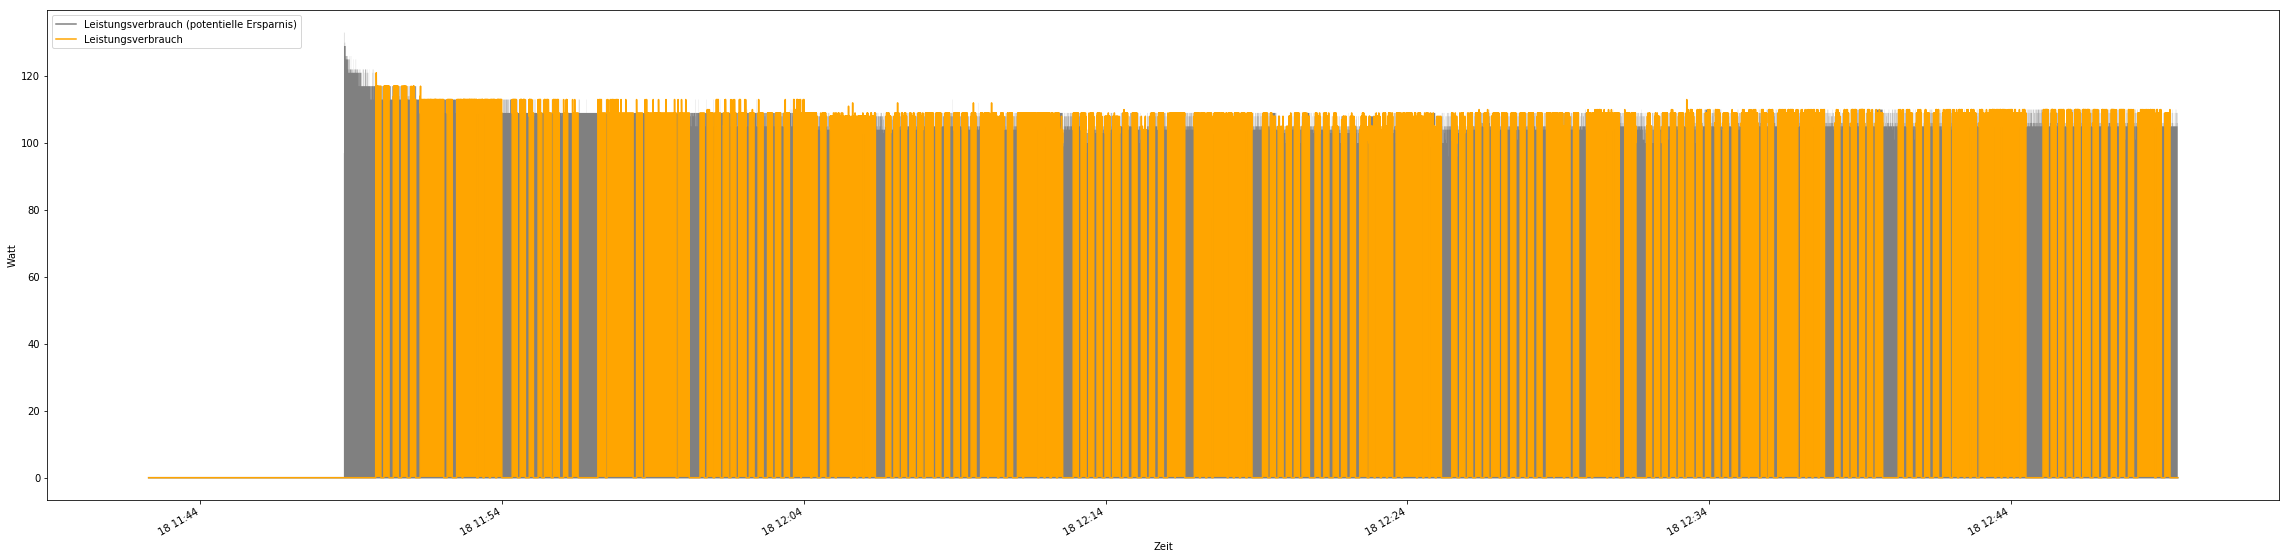

<Figure size 9528x2317 with 0 Axes>

In [24]:
fig, axes = plt.subplots(figsize=(40,10))
axes.set_ylabel("Watt")

active_pm = powermeter_inactive[powermeter_inactive["is_powermeter_sensor"] == 0.0].copy()
inactive_pm = powermeter_inactive[powermeter_inactive["is_powermeter_sensor"] == 0.0][powermeter_inactive["is_idle"]== 0.5].copy()

inactive_pm.plot(label="Leistungsverbrauch (potentielle Ersparnis)", color='grey', ax=axes, x='Zeit', y='dWert', drawstyle="steps-post");
axes.fill_between(inactive_pm['Zeit'].values, inactive_pm['Wert'], facecolor='grey', alpha=1, step="post")

active_pm.plot(label="Leistungsverbrauch", color='orange', ax=axes, x='Zeit', y='dWert', drawstyle="steps-post");
axes.fill_between(active_pm['Zeit'].values, active_pm['dWert'], facecolor='orange', alpha=1, step="post")

axes.legend(loc='upper left')

isac_plotter.savePlotLocal("temporary-generated-files/plot-11.png")

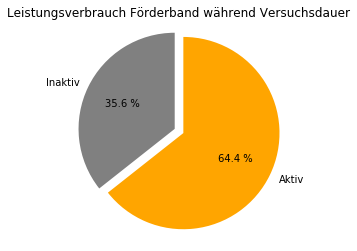

<Figure size 1482x1032 with 0 Axes>

In [25]:
labels = 'Inaktiv', 'Aktiv'
colors = ['grey', 'orange']

sizes = [inactive_pm['amount_idle'].max(),   # Förderband Inaktiv
         active_pm['amount_active'].max()] # Förderband Aktiv
explode = (0, 0.1)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f %%', startangle=90, colors=colors)
ax.axis('equal')

plt.title("Leistungsverbrauch Förderband während Versuchsdauer")

isac_plotter.savePlotLocal("temporary-generated-files/plot-12.png")

plt.show()

### Berechnung Leistungsverbrauch

In [26]:
def wms_to_kwh(value):
    value_watt_seconds = value * 0.000001
    value_watt_hours = value_watt_seconds / 3600
    value_kilo_watt_hours = value_watt_hours / 1000
    return value_kilo_watt_hours

##### Berechnung Leistungsverbrauch Förderband Gesamt

In [27]:
# watt_micro_seconds
amount_idle_max = powermeter_inactive['amount_idle'].max()
amount_active_max = powermeter_inactive['amount_active'].max()

value_kwh_active_and_idle = wms_to_kwh(amount_idle_max + amount_active_max)
value_kwh_idle = wms_to_kwh(amount_idle_max)
value_kwh_active = wms_to_kwh(amount_active_max)
str(value_kwh_active_and_idle) + ' kWh'

'0.08953522333333333 kWh'

##### Berechnung Leistungsverbrauch Förderband inaktiv

In [28]:
value_kwh_idle = wms_to_kwh(amount_idle_max)
str(value_kwh_idle) + ' kWh'

'0.03190922833333333 kWh'

##### Berechnung Leistungsverbrauch Förderband aktiv

In [29]:
value_kwh_active = wms_to_kwh(amount_active_max)
str(value_kwh_active) + ' kWh'

'0.057625995 kWh'

### Mögliche Leistungsersparnis, wenn das Förderband bei Inaktivität abgeschaltet wird
Das Förderband gilt als inaktiv, wenn sich kein Werkstückträger auf dem Förderband befindet

In [30]:
print('Förderband Gesamtverbrauch')
time_start = powermeter['Zeit'][0]
time_end = powermeter['Zeit'][powermeter['Zeit'].index[-1]]
time_delta = time_end - time_start
print(str('Versuchsdauer: ' + str(time_delta)))
print(str(value_kwh_active_and_idle) + ' kWh')
print('')

print('Förderband Verbrauch mit transportiertem Werkstückträger')
print(str(value_kwh_active) + ' kWh')
print('')

print('Förderband Verbrauch ohne transportierten Werkstückträger')
print(str(value_kwh_idle) + ' kWh')
print('')

print('Mögliche Einsparung:')
avoidable_power_usage = value_kwh_idle / (value_kwh_active_and_idle / 100)
print(str(value_kwh_idle) + ' kWh')
print("%.2f" % round(avoidable_power_usage, 2) + ' %')
print('')

Förderband Gesamtverbrauch
Versuchsdauer: 0 days 01:07:15.581000
0.08953522333333333 kWh

Förderband Verbrauch mit transportiertem Werkstückträger
0.057625995 kWh

Förderband Verbrauch ohne transportierten Werkstückträger
0.03190922833333333 kWh

Mögliche Einsparung:
0.03190922833333333 kWh
35.64 %

